###  Imports

In [1]:
import pandas as pd
import torch

import fiftyone as fo
import fiftyone.zoo as foz
from fiftyone import ViewField as F

from dataset import FiftyOneTorchDataset
from model import create_model
from utils import add_detections, get_transforms

import config
import pickle

torch.manual_seed(1)

Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
NumExpr defaulting to 8 threads.


In [2]:
# dataset_name = "coco-2017-validation"
dataset_name = "ImageNet_validation"

# The directory containing the dataset to import
dataset_dir = "C:/Data_drive/Data/Imagenet/ImageNet/imagenet_val_dataset/imagenet_val_dataset"

In [3]:
#fo.core.dataset.delete_non_persistent_datasets()

In [4]:
# Check if the datasets exist on this machine
if fo.core.dataset.dataset_exists(dataset_name):

    fo_dataset = fo.load_dataset(dataset_name) # if the dataset  exists, load it
else:
    if dataset_name == "coco-2017-validation":
        fo_dataset = foz.load_zoo_dataset("coco-2017", "validation")
    else: # if the dataset isnt coco, we will load it from the machine
        fo_dataset = fo.Dataset.from_dir(
        dataset_dir=dataset_dir,
        dataset_type=fo.types.VOCDetectionDataset,
        name=dataset_name,
        )



if dataset_name == "ImageNet_validation":
    with open('dataset_analysis/imagenet_dict_mapping.pkl', 'rb') as f:
                imagenet_class_mapping = pickle.load(f)
    fo_dataset = fo_dataset.map_labels("ground_truth", imagenet_class_mapping)


#needed to calculate image height and width
fo_dataset.compute_metadata()
#create the session to view the dataset
session = fo.launch_app(fo_dataset)

 100% |█████████████| 50000/50000 [3.9m elapsed, 0s remaining, 183.4 samples/s]      


In [5]:
# create the list of labels needed for evaluation, if evaluating on all labels, leave empty

known_unknowns = ['lizard', 'turtle', 'pen', 'cowboy hat', 'tank']
known_knowns = ['clock', 'vase', 'toaster', 'microwave', 'mouse', 'potted plant', 'sports ball', 'zebra', 'dog', 'bird', 'bench', 'parking meter', 'airplane', 'bicycle']



dataset_class_labels = known_knowns + known_unknowns

model_class_labels = known_knowns + known_unknowns


In [6]:
#get the transformations needed for the images
_, test_transforms = get_transforms()

if len(dataset_class_labels) > 0:

    item_view = fo_dataset.filter_labels("ground_truth",
            F("label").is_in(dataset_class_labels))

    # find the class with the fewest examples
    class_count = item_view.count_values("ground_truth.detections.label")
    smallest_class = min(class_count, key=class_count.get) # find the key of the smallest class

    id = set() # create a set to contain the image ids

    for dataset_class in item_view.distinct("ground_truth.detections.label"): # loop through all of the class labels
        class_view = item_view.filter_labels("ground_truth",
            F("label").is_in(dataset_class)) # create a view from which to sample the class
        sample_ids = class_view.take(class_count[smallest_class], seed = 51) # take the number of classes based on the smallest class

        for sample in sample_ids:
            id.add(sample.id) # add the image ids to the set
    item_view = item_view.select(id) # create a view based on these images

    known_view = item_view.filter_labels("ground_truth",
            F("label").is_in(known_knowns))


    unknown_view = item_view.filter_labels("ground_truth",
            F("label").is_in(known_unknowns))


    # use our dataset and defined transformations
    known_evaluation_dataset = FiftyOneTorchDataset(known_view, test_transforms,
        classes=known_knowns)

    # use our dataset and defined transformations
    unknown_evaluation_dataset = FiftyOneTorchDataset(unknown_view, test_transforms,
        classes=known_unknowns)

    print(f'Evaluating on {len(known_evaluation_dataset)} known samples')
    print(f'Evaluating on {len(unknown_evaluation_dataset)} unknown samples')
else: # if we do not provide labels of interest
    item_view = fo_dataset

    #create an item list for use later
    dataset_class_labels = fo_dataset.distinct("ground_truth.detections.label")


print(f'Evaluating on {len(item_view)} samples')



# use our dataset and defined transformations
evaluation_dataset = FiftyOneTorchDataset(item_view, test_transforms,
        classes=dataset_class_labels)

session.view = item_view

# add a blank line dropped during classification
if model_class_labels[0] != 'background':
     model_class_labels.insert(0,'background')

Evaluating on 742 known samples
Evaluating on 271 unknown samples
Evaluating on 1013 samples


In [7]:
# for some items, CLIP may do better with different textual descriptions

replacements = {
    'mouse': 'computer mouse',
}

for k, v in replacements.items():
    CLIP_list = [v if item == k else item for item in model_class_labels]

print(CLIP_list)

['background', 'clock', 'vase', 'toaster', 'microwave', 'computer mouse', 'potted plant', 'sports ball', 'zebra', 'dog', 'bird', 'bench', 'parking meter', 'airplane', 'bicycle', 'lizard', 'turtle', 'pen', 'cowboy hat', 'tank']


# Check CLIP RPN performance

In [8]:
# test out the trained CLIP-FRCNN
MODEL_TYPE = 'CLIP-RPN'
WEIGHTS_NAME='CLIP-RPN_rpn_full_training epoch_30.pth'

# tokenize item list for CLIP
import clip
_, preprocess = clip.load("RN50", device=config.DEVICE)

# create the model
clip_frcnn_model = create_model(MODEL_TYPE, classes=CLIP_list)

# load the pre-trained model
checkpoint = torch.load(WEIGHTS_NAME)
clip_frcnn_model.load_state_dict(checkpoint['model_state_dict'])
epoch = checkpoint['epoch']

print(f'loaded checkpoint at epoch {epoch}')

# set to evaluation mode
clip_frcnn_model.eval()

loaded checkpoint at epoch 30


ZeroShotOD(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): FeatureExtractor(
    (model): ModifiedResNet(
      (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (avgpool): AvgPool2d(kernel_size=2, stride=2, padding=0)
      (relu): ReLU(inplace=True)
      (layer1): Sequential(
        (0): Bottleneck(
          (con

In [9]:
# a helper funciton to evaluate the model on certain datasets
def evaluate_model(model , field_name, evaluation_dataset, fiftyone_Dataset, classes = dataset_class_labels, BCC=False, iou=0.5, eps = 35, labelmap=dataset_class_labels):
    # model - the object detection model
    # field_name - the name used to add the model to FiftyOne
    # evaluation_dataset - the FiftyOne view on which to calculate the data
    # fiftyone_Dataset - the full FiftyOne dataset
    # Classes - the class list on which to evaluate the model
    # BCC - use Bounding box Clustering and Consolidation
    # iou - the iou threshold for nms
    # eps - the eps_neighborhood parameter from DBSCAN
    # labelmap - the mapping of model class number to dataset class number

    add_detections(model, evaluation_dataset, fiftyone_Dataset, field_name=field_name, PRED_CLUSTERING=BCC, labelmap = labelmap, eps = eps)

    evaluation = fo.evaluate_detections(
        item_view,
        field_name,
        classes=classes,
        eval_key=field_name,
        compute_mAP=True,
        iou=iou,
    )

    return evaluation

In [10]:
# find performance without clustering

iou = .1
known_no_cluster_evaluation = evaluate_model(clip_frcnn_model,
                                       evaluation_dataset = known_evaluation_dataset,
                                       field_name = "clip_RPN_predictions_no_clustering",
                                       fiftyone_Dataset = fo_dataset,
                                       classes = known_knowns,
                                       BCC=False,
                                       iou=iou,
                                       labelmap=dataset_class_labels,
                                       )
unknown_no_cluster_evaluation = evaluate_model(clip_frcnn_model,
                                       evaluation_dataset = unknown_evaluation_dataset,
                                       field_name = "clip_RPN_predictions_no_clustering",
                                       fiftyone_Dataset = fo_dataset,
                                       classes = known_unknowns,
                                       BCC=False,
                                       iou=iou,
                                       labelmap=dataset_class_labels,
                                       )

print(f'Known mAP (no BCC): {known_no_cluster_evaluation.mAP()}')
known_no_cluster_evaluation.print_report()
print(f'Unknown mAP (no BCC): {unknown_no_cluster_evaluation.mAP()}')
unknown_no_cluster_evaluation.print_report()

Using device cuda
 100% |█████████████████| 742/742 [4.4m elapsed, 0s remaining, 10.7 samples/s]      
Evaluating detections...
 100% |███████████████| 1013/1013 [22.9s elapsed, 0s remaining, 48.8 samples/s]      
Performing IoU sweep...
 100% |███████████████| 1013/1013 [37.4s elapsed, 0s remaining, 30.4 samples/s]      
Using device cuda
 100% |█████████████████| 271/271 [24.6s elapsed, 0s remaining, 11.1 samples/s]      
Evaluating detections...
 100% |███████████████| 1013/1013 [28.4s elapsed, 0s remaining, 37.8 samples/s]      
Performing IoU sweep...
 100% |███████████████| 1013/1013 [46.5s elapsed, 0s remaining, 27.4 samples/s]      
Known mAP (no BCC): 0.007001068181136371
               precision    recall  f1-score   support

        clock       0.02      0.52      0.05        63
         vase       0.04      0.54      0.07        70
      toaster       0.03      0.36      0.05        64
    microwave       0.02      0.61      0.04        57
        mouse       0.01      0.62

In [11]:
# find performance without clustering

iou = .5
known_no_cluster_evaluation = evaluate_model(clip_frcnn_model,
                                       evaluation_dataset = known_evaluation_dataset,
                                       field_name = "clip_RPN_predictions_no_clustering",
                                       fiftyone_Dataset = fo_dataset,
                                       classes = known_knowns,
                                       BCC=False,
                                       iou=iou,
                                       labelmap=dataset_class_labels,
                                       )
unknown_no_cluster_evaluation = evaluate_model(clip_frcnn_model,
                                       evaluation_dataset = unknown_evaluation_dataset,
                                       field_name = "clip_RPN_predictions_no_clustering",
                                       fiftyone_Dataset = fo_dataset,
                                       classes = known_unknowns,
                                       BCC=False,
                                       iou=iou,
                                       labelmap=dataset_class_labels,
                                       )

print(f'Known mAP (no BCC): {known_no_cluster_evaluation.mAP()}')
known_no_cluster_evaluation.print_report()
print(f'Unknown mAP (no BCC): {unknown_no_cluster_evaluation.mAP()}')
unknown_no_cluster_evaluation.print_report()

Using device cuda
 100% |█████████████████| 742/742 [1.6m elapsed, 0s remaining, 9.4 samples/s]      
Evaluating detections...
 100% |███████████████| 1013/1013 [27.6s elapsed, 0s remaining, 42.6 samples/s]      
Performing IoU sweep...
 100% |███████████████| 1013/1013 [46.0s elapsed, 0s remaining, 27.7 samples/s]      
Using device cuda
 100% |█████████████████| 271/271 [29.7s elapsed, 0s remaining, 9.5 samples/s]      
Evaluating detections...
 100% |███████████████| 1013/1013 [27.9s elapsed, 0s remaining, 42.9 samples/s]      
Performing IoU sweep...
 100% |███████████████| 1013/1013 [45.8s elapsed, 0s remaining, 28.0 samples/s]      
Known mAP (no BCC): 0.007001068181136371
               precision    recall  f1-score   support

        clock       0.02      0.43      0.04        63
         vase       0.03      0.37      0.05        70
      toaster       0.01      0.11      0.02        64
    microwave       0.01      0.30      0.02        57
        mouse       0.00      0.25  

## Find performance with clustering

In [12]:
eps = 35
iou = .1

BCC_evaluation = evaluate_model(clip_frcnn_model,
                                evaluation_dataset = evaluation_dataset,
                                field_name = f"clip_RPN_predictions_eps_{eps}",
                                fiftyone_Dataset = fo_dataset,
                                BCC=True,
                                iou=iou,
                                eps= eps
                                )

map = BCC_evaluation.mAP()
print(f'mAP = {map}')
BCC_evaluation.print_report()

Using device cuda
 100% |███████████████| 1013/1013 [2.2m elapsed, 0s remaining, 9.6 samples/s]      
Evaluating detections...
 100% |███████████████| 1013/1013 [5.5s elapsed, 0s remaining, 186.4 samples/s]      
Performing IoU sweep...
 100% |███████████████| 1013/1013 [5.7s elapsed, 0s remaining, 186.8 samples/s]      
mAP = 0.016176742240240776
               precision    recall  f1-score   support

   background       0.00      0.00      0.00         0
        clock       0.32      0.51      0.39        63
         vase       0.38      0.50      0.43        70
      toaster       0.14      0.25      0.18        64
    microwave       0.23      0.51      0.32        57
        mouse       0.04      0.35      0.07        65
 potted plant       0.21      0.41      0.28       165
  sports ball       0.14      0.45      0.21        94
        zebra       0.28      0.76      0.41        88
          dog       0.15      0.86      0.25        74
         bird       0.18      0.88      0.31

In [13]:
eps = 35
iou=0.5
BCC_evaluation = evaluate_model(clip_frcnn_model,
                                evaluation_dataset = evaluation_dataset,
                                field_name = f"clip_RPN_predictions_eps_{eps}",
                                fiftyone_Dataset = fo_dataset,
                                BCC=True,
                                iou=iou,
                                eps= eps
                                )

map = BCC_evaluation.mAP()
print(f'mAP = {map}')
BCC_evaluation.print_report()

Using device cuda
 100% |███████████████| 1013/1013 [2.3m elapsed, 0s remaining, 9.6 samples/s]      
Evaluating detections...
 100% |███████████████| 1013/1013 [5.5s elapsed, 0s remaining, 187.2 samples/s]      
Performing IoU sweep...
 100% |███████████████| 1013/1013 [5.6s elapsed, 0s remaining, 187.2 samples/s]      
mAP = 0.016176742240240776
               precision    recall  f1-score   support

   background       0.00      0.00      0.00         0
        clock       0.15      0.24      0.18        63
         vase       0.18      0.23      0.20        70
      toaster       0.03      0.06      0.04        64
    microwave       0.06      0.14      0.09        57
        mouse       0.01      0.11      0.02        65
 potted plant       0.06      0.12      0.08       165
  sports ball       0.05      0.16      0.08        94
        zebra       0.11      0.31      0.17        88
          dog       0.11      0.64      0.19        74
         bird       0.11      0.52      0.18

In [14]:
# Test on small objects only
# Bboxes are in [top-left-x, top-left-y, width, height] format
bbox_area = F("bounding_box")[2] * F("bounding_box")[3]

small_view = item_view.filter_labels("ground_truth", bbox_area < 0.2)
# use our dataset and defined transformations
small_object_dataset = FiftyOneTorchDataset(small_view, test_transforms,
        classes=dataset_class_labels)
iou=0.5
eps = 35
BCC_evaluation = evaluate_model(clip_frcnn_model,
                                evaluation_dataset = small_object_dataset,
                                field_name = f"clip_RPN_small_predictions_eps_{eps}",
                                fiftyone_Dataset = fo_dataset,
                                BCC=True,
                                iou=iou,
                                eps= eps
                                )

map = BCC_evaluation.mAP()
print(f'mAP = {map}')
BCC_evaluation.print_report()

Using device cuda
 100% |█████████████████| 394/394 [1.0m elapsed, 0s remaining, 8.0 samples/s]       
Evaluating detections...
 100% |███████████████| 1013/1013 [4.2s elapsed, 0s remaining, 240.8 samples/s]      
Performing IoU sweep...
 100% |███████████████| 1013/1013 [3.8s elapsed, 0s remaining, 295.3 samples/s]      
mAP = 0.00485038880779554
               precision    recall  f1-score   support

   background       0.00      0.00      0.00         0
        clock       0.10      0.06      0.08        63
         vase       0.10      0.07      0.08        70
      toaster       0.00      0.00      0.00        64
    microwave       0.04      0.05      0.05        57
        mouse       0.02      0.08      0.03        65
 potted plant       0.04      0.06      0.05       165
  sports ball       0.04      0.06      0.05        94
        zebra       0.07      0.08      0.07        88
          dog       0.05      0.11      0.07        74
         bird       0.04      0.09      0.06

In [49]:
# Test on large objects only
# Bboxes are in [top-left-x, top-left-y, width, height] format
bbox_area = F("bounding_box")[2] * F("bounding_box")[3]

large_view = item_view.filter_labels("ground_truth", bbox_area > 0.2)
# use our dataset and defined transformations
large_object_dataset = FiftyOneTorchDataset(large_view, test_transforms,
        classes=dataset_class_labels)

iou=0.5
eps = 35

BCC_evaluation = evaluate_model(clip_frcnn_model,
                                evaluation_dataset = large_object_dataset,
                                field_name = f"clip_RPN_large_predictions_eps_{eps}",
                                fiftyone_Dataset = fo_dataset,
                                BCC=True,
                                iou=iou,
                                eps= eps
                                )

map = BCC_evaluation.mAP()
print(f'mAP = {map}')
BCC_evaluation.print_report()

Using device cuda
 100% |█████████████████| 699/699 [1.8m elapsed, 0s remaining, 7.6 samples/s]      
Evaluating detections...
 100% |███████████████| 1013/1013 [7.3s elapsed, 0s remaining, 137.5 samples/s]      
Performing IoU sweep...
 100% |███████████████| 1013/1013 [7.7s elapsed, 0s remaining, 135.8 samples/s]      
mAP = 0.016176742240240776
               precision    recall  f1-score   support

   background       0.00      0.00      0.00         0
        clock       0.15      0.24      0.18        63
         vase       0.18      0.23      0.20        70
      toaster       0.03      0.06      0.04        64
    microwave       0.06      0.14      0.09        57
        mouse       0.01      0.11      0.02        65
 potted plant       0.06      0.12      0.08       165
  sports ball       0.05      0.16      0.08        94
        zebra       0.11      0.31      0.17        88
          dog       0.11      0.64      0.19        74
         bird       0.11      0.52      0.18

#### Sensitivity Study

In [16]:
# find performance with clustering

results = []
best_map = 0

for eps in range(5, 50, 5):
    print(f'epsilon = {eps}')

    evaluation = evaluate_model(clip_frcnn_model,
                                evaluation_dataset = evaluation_dataset,
                                field_name = f"clip_RPN_predictions_eps_{eps}",
                                fiftyone_Dataset = fo_dataset,
                                BCC=True,
                                iou=0.5,
                                eps= eps
                                )

    map = evaluation.mAP()
    print(f'mAP = {map}')

    results.append([eps, map])
    if map > best_map:
        best_eps = eps
        best_map = map
        best_eval = evaluation

print(f'best_mAP = {best_map}')
print(f'best_eps = {best_eps}')
best_eval.print_report()

epsilon = 5
Using device cuda
 100% |███████████████| 1013/1013 [2.3m elapsed, 0s remaining, 9.3 samples/s]      
Evaluating detections...
 100% |███████████████| 1013/1013 [5.0s elapsed, 0s remaining, 202.8 samples/s]      
Performing IoU sweep...
 100% |███████████████| 1013/1013 [5.1s elapsed, 0s remaining, 206.7 samples/s]      
mAP = 0.013848216871582131
epsilon = 10
Using device cuda
 100% |███████████████| 1013/1013 [2.4m elapsed, 0s remaining, 9.5 samples/s]      
Evaluating detections...
 100% |███████████████| 1013/1013 [5.7s elapsed, 0s remaining, 175.2 samples/s]      
Performing IoU sweep...
 100% |███████████████| 1013/1013 [5.6s elapsed, 0s remaining, 191.3 samples/s]      
mAP = 0.014490400290133697
epsilon = 15
Using device cuda
 100% |███████████████| 1013/1013 [2.4m elapsed, 0s remaining, 8.9 samples/s]      
Evaluating detections...
 100% |███████████████| 1013/1013 [5.8s elapsed, 0s remaining, 183.8 samples/s]      
Performing IoU sweep...
 100% |███████████████| 1

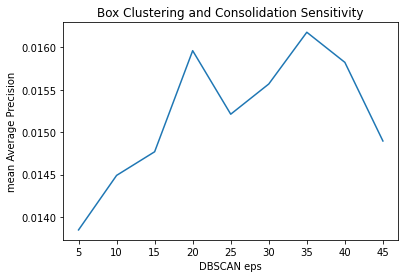

In [40]:
# importing the required module
import matplotlib.pyplot as plt
import pandas as pd
res = pd.DataFrame(results)
# plotting the points
plt.plot(res[0], res[1])

# naming the x axis
plt.xlabel('DBSCAN eps')
# naming the y axis
plt.ylabel('mean Average Precision')

# giving a title to my graph
plt.title('Box Clustering and Consolidation Sensitivity')

# function to show the plot

plt.savefig('Box Clustering and Consolidation Sensitivity.jpg')

# Test against Faster-RCNN

In [17]:
# create the labelmap for the coco dataset
coco_labels = open("dataset_analysis/coco_labels.txt", "r")
coco_list = coco_labels.read().splitlines() # read each line in as a value in a list
coco_list.insert(0,'background') # add the background class
coco_id = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 31, 32, 33, 34,
          35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63,
          64, 65, 67, 70, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 84, 85, 86, 87, 88, 89, 90, 91] # annoyingly, COCO has 90 class ids but only 80 labels
coco = dict(zip(coco_id, coco_list)) # convert it to a dict

## Calculate metrics from the FRCNN using iou 0.1

In [18]:
import torchvision
# load a model pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

iou=.1
pre_trained_known_evaluation = evaluate_model(model,
                                evaluation_dataset = known_evaluation_dataset,
                                field_name = "FRCNN_known_predictions",
                                fiftyone_Dataset = fo_dataset,
                                classes = known_knowns,
                                iou=iou,
                                labelmap=coco
                                )
pre_trained_unknown_evaluation = evaluate_model(model,
                                evaluation_dataset = unknown_evaluation_dataset,
                                field_name = "FRCNN_unknown_predictions",
                                fiftyone_Dataset = fo_dataset,
                                classes = known_unknowns,
                                iou=iou,
                                labelmap=coco
                                )

print(f'mAP: {pre_trained_known_evaluation.mAP()}')
pre_trained_known_evaluation.print_report()

print(f'mAP: {pre_trained_unknown_evaluation.mAP()}')
pre_trained_unknown_evaluation.print_report()

Using device cuda
 100% |█████████████████| 742/742 [1.9m elapsed, 0s remaining, 7.7 samples/s]      
Evaluating detections...
 100% |███████████████| 1013/1013 [10.3s elapsed, 0s remaining, 92.2 samples/s]      
Performing IoU sweep...
 100% |███████████████| 1013/1013 [13.8s elapsed, 0s remaining, 81.9 samples/s]      
Using device cuda
 100% |█████████████████| 271/271 [41.3s elapsed, 0s remaining, 6.6 samples/s]      
Evaluating detections...
 100% |███████████████| 1013/1013 [6.3s elapsed, 0s remaining, 159.5 samples/s]      
Performing IoU sweep...
 100% |███████████████| 1013/1013 [6.5s elapsed, 0s remaining, 160.6 samples/s]      
mAP: 0.43711472188549855
               precision    recall  f1-score   support

        clock       0.24      0.84      0.37        63
         vase       0.17      0.90      0.28        70
      toaster       0.52      0.53      0.53        64
    microwave       0.31      0.79      0.44        57
        mouse       0.36      0.80      0.50        

In [19]:
iou=.5
pre_trained_known_evaluation = evaluate_model(model,
                                evaluation_dataset = known_evaluation_dataset,
                                field_name = "FRCNN_known_predictions",
                                fiftyone_Dataset = fo_dataset,
                                classes = known_knowns,
                                iou=iou,
                                labelmap=coco
                                )
pre_trained_unknown_evaluation = evaluate_model(model,
                                evaluation_dataset = unknown_evaluation_dataset,
                                field_name = "FRCNN_unknown_predictions",
                                fiftyone_Dataset = fo_dataset,
                                classes = known_unknowns,
                                iou=iou,
                                labelmap=coco
                                )

print(f'mAP: {pre_trained_known_evaluation.mAP()}')
pre_trained_known_evaluation.print_report()

print(f'mAP: {pre_trained_unknown_evaluation.mAP()}')
pre_trained_unknown_evaluation.print_report()

Using device cuda
 100% |█████████████████| 742/742 [2.0m elapsed, 0s remaining, 7.1 samples/s]      
Evaluating detections...
 100% |███████████████| 1013/1013 [9.9s elapsed, 0s remaining, 100.8 samples/s]      
Performing IoU sweep...
 100% |███████████████| 1013/1013 [12.3s elapsed, 0s remaining, 83.4 samples/s]      
Using device cuda
 100% |█████████████████| 271/271 [39.7s elapsed, 0s remaining, 7.4 samples/s]      
Evaluating detections...
 100% |███████████████| 1013/1013 [6.1s elapsed, 0s remaining, 168.0 samples/s]      
Performing IoU sweep...
 100% |███████████████| 1013/1013 [6.2s elapsed, 0s remaining, 149.4 samples/s]      
mAP: 0.43711472188549855
               precision    recall  f1-score   support

        clock       0.20      0.68      0.30        63
         vase       0.17      0.90      0.28        70
      toaster       0.51      0.52      0.51        64
    microwave       0.29      0.75      0.42        57
        mouse       0.34      0.75      0.47        

In [24]:
plot = pre_trained_known_evaluation.plot_pr_curves(classes=known_knowns)
plot.show()

FigureWidget({
    'data': [{'customdata': array([0.99967682, 0.99964222, 0.99950137, 0.99922658, 0.99922658, …

In [25]:
plot2 = BCC_evaluation.plot_pr_curves(classes=known_unknowns)
plot2.show()

FigureWidget({
    'data': [{'customdata': array([0.99996078, 0.59719999, 0.49619357, 0.39688331, 0.39688331, …

In [26]:

session.view = item_view